In [71]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,f1_score,recall_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, KernelPCA

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

import pickle
import joblib
from joblib import dump, load

from collections import Counter
from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Data Preprocessing

In [263]:
def file_name_encoding_init(file_names):
    le_filename = preprocessing.LabelEncoder()
    le_filename.fit(file_names)
    dump(le_filename, 'Task A Assets/Task_A_file_name_encoder.joblib') 

def label_encoding_init(labels):
    le_label = preprocessing.LabelEncoder()
    le_label.fit(labels)
    dump(le_label, 'Task A Assets/Task_A_label_encoder.joblib') 

def SMOTE_preprocessing(file_names, labels):
    le_filename = joblib.load('Task A Assets/Task_A_file_name_encoder.joblib')
    le_filename.fit(file_names)
    le_file_names = le_filename.transform(file_names).reshape(-1,1)
    
    sm = SMOTE()
    SMOTE_file_names, SMOTE_labels = sm.fit_resample(le_file_names, labels)
    print("Distribution of image categories post-SMOTE:")
    print(Counter(list(SMOTE_labels)))
    
    SMOTE_file_names = le_filename.inverse_transform(SMOTE_file_names)

    return SMOTE_file_names, SMOTE_labels

def PCA_process(x):
    pca = KernelPCA(kernel='rbf', n_components=800)
    x_flat = np.array([features_2d.flatten() for features_2d in x])
    x_pca = pca.fit_transform(x_flat)
    dump(pca, 'Task A Assets/Task_A_PCA.joblib') 
    return x_pca


def image_processing(data_path,file_names):
    dataset_tumor=[]
    for file_name in file_names:
        file=cv2.imread(data_path+"/image/"+file_name)
        #file_resize=cv2.resize(file,(200,200))/255.
        file_resize=cv2.resize(file,(256,256))
        dataset_tumor.append(file_resize)
    tumor_data = np.array(dataset_tumor)
    return tumor_data

def preprocessing_data(data_path, file, status):

    data=pd.read_csv(data_path+file)
    file_names=list(data['file_name'])
    data['label'] = data['label'].apply(lambda x: "no_tumor" if x == "no_tumor" else "tumor")
    labels=data['label'].values.reshape(-1,1)
    
    if status == 'training':
        
        print("Distribution of image categories:")
        print(Counter(list(data['label'])))
    
        file_name_encoding_init(file_names)
        label_encoding_init(labels)
        
        
        file_names, labels = SMOTE_preprocessing(file_names, labels)
        
        x = image_processing(data_path, file_names)
        x_pca = PCA_process(x)
        x_train,x_test,y_train,y_test = train_test_split(x_pca,labels,test_size=0.2)
        
        
        std = StandardScaler()
        x_train = std.fit_transform(x_train)
        x_test = std.transform(x_test)
        le_label = joblib.load('Task A Assets/Task_A_label_encoder.joblib')
        
        y_train = le_label.transform(y_train)
        y_test = le_label.transform(y_test)

        y_train = y_train.ravel()
        y_test = y_test.ravel()
        
        return x_train, x_test, y_train, y_test

    
    elif status == 'testing':
        le_label = joblib.load('Task A Assets/Task_A_label_encoder.joblib')
        y_test = le_label.transform(labels)
        x_test = image_processing(data_path,file_names) 
                              
        return x_test, y_test
    
def find_model(x_train, y_train):
    classifiers=[KNeighborsClassifier(),svm.SVC()]
    classifierNames=['KNN','SVM']
    parameters=[{'n_neighbors':[1,3,5,7]}, {'kernel':['rbf'],'C':[0.7,2,10]}]

    for i in range(len(classifiers)):
        clf=classifiers[i]
        print('\nSearching best '+classifierNames[i]+' parameters.')
        clf_search= GridSearchCV(clf, parameters[i], scoring = 'accuracy',cv = 5)
        result = clf_search.fit(x_train,y_train)
        best_clf=clf_search.best_estimator_
        
        print("Classifier:",classifierNames[i])
        print("Best Parameters: {}".format(clf_search.best_params_))
        print("Best Validation Accuracy: %f" % (result.best_score_))

        pred=best_clf.predict(x_test)

        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test,pred)
        recall = recall_score(y_test,pred)
        f1score = f1_score(y_test,pred)
        
        print("Classifier Performance:",classifierNames[i])
        print("Test Accuracy: %.4f" %(accuracy))
        print("Test Precision: %.4f" %(precision))
        print("Test Recall: %.4f" %(recall))
        print("Test F1-score: %.4f" %(f1score))
    
def train_SVC(x_train_val,y_train_val):
    
    kf = KFold(n_splits=5,shuffle=True)
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1score = []
    
    
    print("SVC GridSearch with 5-Fold Cross Validation.")
    for train_index, test_index in kf.split(x_train_val):
        x_train, x_val = x_train_val[train_index], x_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]

        # Pipeline
           
        model=svm.SVC(C=0.7,kernel='rbf')
        model.fit(x_train,y_train)

        pred_val=model.predict(x_val)

        val_accuracy.append(accuracy_score(y_val, pred_val))
        val_precision.append(precision_score(y_val, pred_val))
        val_recall.append(f1_score(y_val, pred_val))
        val_f1score.append(recall_score(y_val, pred_val))
        

    average_val_accuracy=sum(val_accuracy)/len(val_accuracy)
    average_val_precision=sum(val_precision)/len(val_precision)
    average_val_recall=sum(val_recall)/len(val_recall)
    average_val_f1score=sum(val_f1score)/len(val_f1score)
    

    print("SVM Classifier 5-Fold CV:")
    print("Average Acc: %.4f" %(average_val_accuracy))
    print("Average Precision: %.4f" %(average_val_precision))
    print("Average recall: %.4f" %(average_val_recall))
    print("Average F1 Score: %.4f \n" %(average_val_f1score))
    

    pickle.dump(model, open("Task A Assets/Task_A_SVM_Model", 'wb'))


def test_model(x_test, y_test):

    loaded_model = pickle.load(open("Task A Assets/Task_A_SVM_Model", 'rb'))
    y_pred_svm = loaded_model.predict(x_test)
    print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred_svm)))
    
    #text report showing the main classification metrics
    print(classification_report(y_test,y_pred_svm))
    plt.figure(figsize = (5,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap = 'Blues')
    plt.show()

## Data Preprocessing (Training)

In [258]:
data_path="dataset/"
file = "label.csv"

x_train_val, x_test, y_train_val, y_test = preprocessing_data(data_path, file, 'training')

Distribution of image categories:
Counter({'tumor': 2546, 'no_tumor': 454})
Distribution of image categories post-SMOTE:
Counter({'tumor': 2546, 'no_tumor': 2546})


C:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


b
(5092, 256, 256, 3)
c
(5092, 800)


## Finding Model (KNN,SVC with GridSearchCV)

In [259]:
find_model(x_train_val, y_train_val)


Searching best KNN parameters.
Classifier: KNN
Best Parameters: {'n_neighbors': 7}
Best Validation Accuracy: 0.682794
Classifier Performance: KNN
Test Accuracy: 0.7026
Test Precision: 0.7395
Test Recall: 0.6442
Test F1-score: 0.6886

Searching best SVM parameters.
Classifier: SVM
Best Parameters: {'C': 0.7, 'kernel': 'rbf'}
Best Validation Accuracy: 0.707090
Classifier Performance: SVM
Test Accuracy: 0.7174
Test Precision: 0.7397
Test Recall: 0.6885
Test F1-score: 0.7131


## Training and Validation (SVC)

In [260]:
train_SVC(x_train_val,y_train_val)

5 Fold Cross Validation is used.
SVM Classifier 5-Fold CV:
Average Acc: 0.7093
Average Precision: 0.7212
Average recall: 0.6987
Average F1 Score: 0.6793 



# Testing (using splitted sample data)

Accuracy on test set: 0.719332679097154
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       499
           1       0.73      0.71      0.72       520

    accuracy                           0.72      1019
   macro avg       0.72      0.72      0.72      1019
weighted avg       0.72      0.72      0.72      1019



<Figure size 360x360 with 0 Axes>

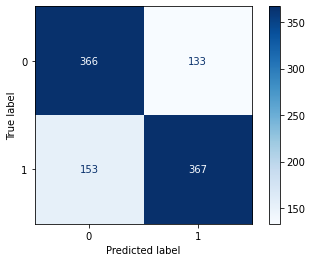

In [261]:
test_model(x_test,y_test)

# TO DO!!!

In [1]:
#add cross validation for svc
#add gridsearch
#tidy up functions